BloomTech Data Science

*Unit 2, Sprint 2, Module 4*

---

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/main/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [ ]:
!pip install category_encoders==2.*
import pandas as pd 
import numpy as np
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Module Project: Classification Metrics

This sprint, the module projects will focus on creating and improving a model for the Tanazania Water Pump dataset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

## Directions

The tasks for this project are as follows:

- **Task 1:** Use `wrangle` function to import training and test data.
- **Task 2:** Split training data into feature matrix `X` and target vector `y`.
- **Task 3:** Split training data into training and validation sets.
- **Task 4:** Establish the baseline accuracy score for your dataset.
- **Task 5:** Build `model`.
- **Task 6:** Calculate the training and validation accuracy score for your model.
- **Task 7:** Plot the confusion matrix for your model.
- **Task 8:** Print the classification report for your model.
- **Task 9:** Identify likely `'non-functional'` pumps in the test set.
- **Task 10:** Find likely `'non-functional'` pumps serving biggest populations.
- **Task 11 (`stretch goal`):** Plot pump locations from Task 10.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `pandas-profiling`
- `plotly`
- `sklearn`


# I. Wrangle Data

In [ ]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path, 
                                  na_values=[0, -2.000000e-08], parse_dates=['date_recorded']), pd.read_csv(tv_path)).set_index('id')
                                  
                      
        df['needs_repair'] = np.where(df['status_group'] == 'functional', 0, 1)
        df.drop(columns='status_group', inplace=True)
    else:
        df = pd.read_csv(fm_path, 
                         na_values=[0, -2.000000e-08], parse_dates=['date_recorded'],
                         index_col='id')

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

     # Create age feature
    df['pump_age'] = df['date_recorded'].dt.year - df['construction_year']
    df.drop(columns='date_recorded', inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(100).T.duplicated().index
                 if df.head(100).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)             

    #if 'status_group' in df:
      #df['needs_repair'] = np.where(df['status_group']=='functional',0,1)
      #df.drop(columns='status_group',inplace=True)
    return df

**Task 1:** Using the above `wrangle` function to read `train_features.csv` and `train_labels.csv` into the DataFrame `df`, and `test_features.csv` into the DataFrame `X_test`.

In [ ]:
df = wrangle('train_features.csv','train_labels.csv')
X_test = wrangle('test_features.csv')
df.columns

Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private',
       'basin', 'region', 'region_code', 'district_code', 'population',
       'public_meeting', 'scheme_management', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'needs_repair', 'pump_age'],
      dtype='object')

# II. Split Data

**Task 2:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

**Note:** You won't need to do a train-test split because you'll use cross-validation instead.

In [ ]:
target = 'needs_repair'
X = df.drop(target,axis=1)
y = df[target]

**Task 3:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42)

# III. Establish Baseline

**Task 4:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [ ]:
baseline_acc = y_train.value_counts(normalize=True)
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0    0.542549
1    0.457451
Name: needs_repair, dtype: float64


In [ ]:
#df['status_group'].value_counts()

#df['needs_repair'] = np.where(df['status_group']=='functional',0,1)



# IV. Build Models

**Task 5:** Build and train your `model`. Include the transformers and predictor that you think are most appropriate for this problem.

In [ ]:
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=25,n_jobs=-1,random_state=42)
)
model.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoin...
communal standpipe multiple    3
improved spring                4
other                          5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                

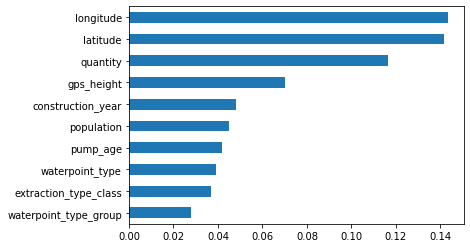

In [ ]:
importances = model.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns
pd.Series(importances,index=features).sort_values().tail(10).plot(kind='barh')

# V. Check Metrics

**Task 6:** Calculate the training and validation accuracy scores for `model`.

In [ ]:
training_acc = model.score(X_train,y_train)
val_acc = model.score(X_val,y_val)

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.993870840457714
Validation Accuracy Score: 0.8067129629629629


**Task 7:** Plot the confusion matrix for your model, using your validation data.

**Note:** Since there are three classes in your target vector, the dimensions of your matrix will be 3x3.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


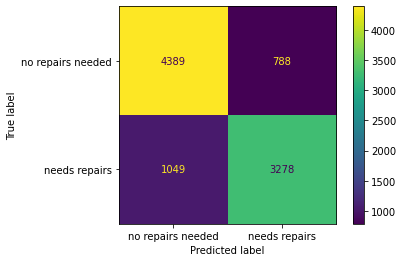

In [ ]:
# Plot 3x3 confusion matrix#

plot_confusion_matrix(model,X_val,y_val,values_format='.0f',display_labels=['no repairs needed','needs repairs'])

Calculating precision and recall for a multiclass problem is a bit of a mess. Fortunately, we can use `sklearn`'s classification report.

**Task 8:**  Print the classification report for your `model`, using your validation data.

In [ ]:
# Print classification report 
print(classification_report(y_val,model.predict(X_val),target_names=['no repairs needed','repairs needed']))

                   precision    recall  f1-score   support

no repairs needed       0.81      0.85      0.83      5177
   repairs needed       0.81      0.76      0.78      4327

         accuracy                           0.81      9504
        macro avg       0.81      0.80      0.80      9504
     weighted avg       0.81      0.81      0.81      9504



# VI. Tune Model

Usually, we use this part of the ML workflow to adjust the hyperparameters of the our model to increase performance based on metrics like accuracy. Today, we'll use it to help maximize the impact of our water pump repairs when resources are scarce. What if we only had funds to repair 100 water pumps?

(This activity is based on a [post](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050) by Lambda alum Michael Brady.)

**Task 9:** Using your model's `predict_proba` method, identify the observations in your **test set** where the model is more than 95% certain that a pump is `'non-functional'`. Put these observations in the DataFrame `X_test_nf`.

In [ ]:
n_inspections = 100
X_test_nf ={
  'y_val':y_val,
  'y_pred_proba':model.predict_proba(X_val)[:,-1],
   
} 
threshold = .95
results = pd.DataFrame(X_test_nf)
mask = (results['y_pred_proba'] > threshold)
sample = results[mask].sample(n_inspections)
sample

,y_val,y_pred_proba
id,,
35170.0,1,0.96
71785.0,1,1.00
4150.0,1,1.00
31688.0,1,1.00
70121.0,1,1.00
...,...,...
46950.0,1,0.96
52120.0,1,1.00
57152.0,1,1.00


**Task 10:** Limit `X_test_nf` to the 100 pumps with the largest associated populations.

In [ ]:
temp = results.merge(df,right_index=True,left_index=True)
X_test_100 = temp.sort_values(by='population',ascending=False).head(100)
X_test_100

,y_val,y_pred_proba,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,needs_repair,pump_age
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
16664.0,1,0.96,50.0,1385.0,33.778061,-6.462070,NaN,Lake Tanganyika,Singida,13,3.0,9000.0,True,VWC,True,2008.0,mono,mono,motorpump,vwc,user-group,pay per bucket,per bucket,salty,salty,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,1,5.0
6280.0,0,1.00,10.0,904.0,37.101187,-3.400788,NaN,Pangani,Kilimanjaro,3,5.0,8000.0,True,Water Board,True,1999.0,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,0,14.0
13182.0,1,0.08,NaN,1574.0,34.707703,-1.683425,NaN,Lake Victoria,Mara,20,2.0,7500.0,True,VWC,NaN,2008.0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,salty,salty,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,1,4.0
23984.0,0,0.24,30.0,39.0,39.288332,-6.968875,NaN,Wami / Ruvu,Pwani,60,43.0,6922.0,True,VWC,False,2010.0,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,0,1.0
14131.0,0,0.00,30.0,43.0,39.292457,-6.977986,NaN,Wami / Ruvu,Pwani,60,43.0,6922.0,True,VWC,False,2010.0,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51337.0,1,0.24,NaN,173.0,37.602484,-7.464288,NaN,Wami / Ruvu,Morogoro,5,2.0,1900.0,True,VWC,True,1985.0,nira/tanira,nira/tanira,handpump,vwc,user-group,pay when scheme fails,on failure,soft,good,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,1,26.0
49338.0,1,0.96,100.0,196.0,39.495034,-10.278200,NaN,Ruvuma / Southern Coast,Lindi,80,23.0,1885.0,True,VWC,False,2003.0,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe multiple,communal standpipe,1,10.0
36409.0,1,0.40,NaN,818.0,29.681127,-4.903545,NaN,Lake Tanganyika,Kigoma,16,4.0,1860.0,True,VWC,True,2000.0,other,other,other,vwc,user-group,never pay,never pay,soft,good,dry,shallow well,shallow well,groundwater,other,other,1,13.0


# VII. Communicate Results

**Task 11 (`stretch goal`):** Create a scatter plot with the location of the 100 pumps in `X_test_nf`.

**Note:** If you want to make this a **`super stretch goal`**, create a Mapbox scatter plot using [Plotly](https://plotly.github.io/plotly.py-docs/generated/plotly.express.scatter_mapbox.html).

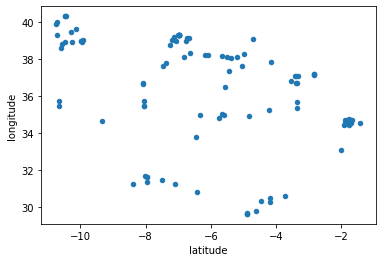

In [ ]:
import matplotlib.pyplot as plt
X_test_100.plot.scatter(x='latitude',y='longitude')